### 【機械学習】

In [15]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', FutureWarning)

# シングルスイープのデータ
df = pd.read_csv("./data/01_single/output/ADS_out.csv", header=0)

# 不要なカラムを削除
df = df.drop(['Unnamed: 0.1'],axis=1)

# Refのリネーム
df = df.rename(columns={'Unnamed: 0':'Ref'})

df.head(1)

,Ref,Val,VTUNE12,fpeak,gain,fimg,img
0,C1,0.25,0.5,366000000,5.646318,266000000,123.9643


### デフォルトパラメータを入れる

In [16]:
# REFカラムの設定
ncolumn = ["C1","C2","C3","C4","C5","C6","C7",\
           "C8","C9","C10","C11","C12","C13",\
           "L1","L2","L3"]

# デフォルトパラメータ
# 各Refの行に新しい列へ値を入れる
for i, col in enumerate(ncolumn):
  if(i==0):
    df[col] = 12 # C1
  elif(i==1):
    df[col] = 27 # C2
  elif(i==2):
    df[col] = 6 # C3
  elif(i==3):
    df[col] = 2 # C4
  elif(i==4):
    df[col] = 27 # C5
  elif(i==5):
    df[col] = 6 # C6
  elif(i==6):
    df[col] = 4 # C7
  elif(i==7):
    df[col] = 18 # C8
  elif(i==8):
    df[col] = 4 # C9
  elif(i==9):
    df[col] = 4 # C10
  elif(i==10):
    df[col] = 18 # C11
  elif(i==11):
    df[col] = 2 # C12
  elif(i==12):
    df[col] = 10 # C13
  elif(i==13):
    df[col] = 27 # L1
  elif(i==14):
    df[col] = 27 # L2
  elif(i==15):
    df[col] = 11 # L3

df.head(1)

,Ref,Val,VTUNE12,fpeak,gain,fimg,img,C1,C2,C3,...,C7,C8,C9,C10,C11,C12,C13,L1,L2,L3
0,C1,0.25,0.5,366000000,5.646318,266000000,123.9643,12,27,6,...,4,18,4,4,18,2,10,27,27,11


In [17]:
# Refと一致する箇所に値を代入する
for col in ncolumn:
  df.loc[df.loc[:,"Ref"] == col,col] = df["Val"]

# 最後に不要なカラムを消す
df = df.drop("Ref", axis=1)
df = df.drop("Val", axis=1)

df.head(1)

,VTUNE12,fpeak,gain,fimg,img,C1,C2,C3,C4,C5,...,C7,C8,C9,C10,C11,C12,C13,L1,L2,L3
0,0.5,366000000,5.646318,266000000,123.9643,0.25,27.0,6.0,2.0,27.0,...,4.0,18.0,4.0,4.0,18.0,2.0,10.0,27.0,27.0,11.0


### 訓練データ、テストデータを作成

In [18]:
# 共通カラム + T12
ncolumn = ["C1","C2","C3","C4","C5","C6","C7",\
           "C8","C9","C10","C11","C12","C13",\
           "L1","L2","L3","VTUNE12"]

# [訓練データ]
# 「共通カラム(REF)」 + 「ターゲット列」のデータフレームを作る
train_df1 = pd.concat([df[ncolumn],df["fpeak"]],axis=1) # ピーク周波数
train_df2 = pd.concat([df[ncolumn],df["gain"]],axis=1) # ゲイン
train_df3 = pd.concat([df[ncolumn],df["img"]],axis=1) # イメージ

# [テストデータ]
# 訓練データからターゲット列を落とす
test_df1 = train_df1.drop("fpeak",axis=1)
test_df2 = train_df2.drop("gain",axis=1)
test_df3 = train_df3.drop("img",axis=1)

In [19]:
# LOGスケールに変換(ピーク周波数だけスケール大きいため)
train_df1["fpeak"] = np.log(train_df1["fpeak"])

In [20]:
# ライブラリ読み込み
import lightgbm as lgb
from sklearn.model_selection import KFold # K分割

# パラメータ設定
# (サロゲートモデルは過剰なチューニングしないこと)
lgbm_params = {
    'objective': 'regression',
    "device": "cpu",
    'metric': 'mae',
    'boosting_type': 'gbdt', # BoostingのType
    'learning_rate': 0.01,   # 学習率　default = 0.1
    'random_state': 42,
    'verbose': -1            # ログ出力の制御
    }

# 訓練データから除外するカラム(ターゲット)
RMV1 = ["fpeak"]
RMV2 = ["gain"]
RMV3 = ["img"]

# 各データフレームの特徴量(ターゲットだけ外す)
FEATURES1 = [c for c in train_df1.columns if not c in RMV1]
FEATURES2 = [c for c in train_df2.columns if not c in RMV2]
FEATURES3 = [c for c in train_df3.columns if not c in RMV3]

In [21]:
def model_LGB(train, test, FEATURES, Target):

    FOLDS = 5
    kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

    pred_lgb = np.zeros(len(test))
    models = []

    # ★ Foldごとの学習履歴を保存
    evals_result = []

    for i, (train_index, valid_index) in enumerate(kf.split(train)):

        print("#" * 25)
        print(f"### Fold {i+1}")
        print("#" * 25)

        x_train = train.loc[train_index, FEATURES].copy()
        y_train = train.loc[train_index, Target]

        x_valid = train.loc[valid_index, FEATURES].copy()
        y_valid = train.loc[valid_index, Target]

        lgb_train = lgb.Dataset(x_train, y_train)
        lgb_eval  = lgb.Dataset(x_valid, y_valid, reference=lgb_train)

        # ★ Fold専用のdictを用意
        eval_result_fold = {}

        model_lgb = lgb.train(
            lgbm_params,
            lgb_train,
            num_boost_round=2000,
            valid_sets=[lgb_train, lgb_eval],
            valid_names=["train", "valid"],
            callbacks=[
                lgb.early_stopping(stopping_rounds=100, verbose=False),
                lgb.record_evaluation(eval_result_fold),
                lgb.log_evaluation(100),
            ]
        )

        models.append(model_lgb)
        evals_result.append(eval_result_fold)

        pred_lgb[valid_index] = model_lgb.predict(
            x_valid,
            num_iteration=model_lgb.best_iteration
        )

    return models, pred_lgb, evals_result

In [22]:
# 1.ピーク周波数
model1 = []
lgb_output1 = []
eval_result1 = {}
model1, lgb_output1, eval_result1 = model_LGB(train_df1, test_df1, FEATURES1, RMV1)

# 2.ゲイン
model2 = []
lgb_output2 = []
eval_result2 = {}
model2, lgb_output2, eval_result2 = model_LGB(train_df2, test_df2, FEATURES2, RMV2)

# 3.イメージ
model3 = []
lgb_output3 = []
eval_result3 = {}
model3, lgb_output3, eval_result3 = model_LGB(train_df3, test_df3, FEATURES3, RMV3)

#########################
### Fold 1
#########################
[100]	train's l1: 0.0375523	valid's l1: 0.0370628
[200]	train's l1: 0.0187293	valid's l1: 0.0183978
[300]	train's l1: 0.011107	valid's l1: 0.0109613
[400]	train's l1: 0.00796927	valid's l1: 0.00797901
[500]	train's l1: 0.00673824	valid's l1: 0.00686649
[600]	train's l1: 0.00615676	valid's l1: 0.00635154
[700]	train's l1: 0.00585138	valid's l1: 0.00607421
[800]	train's l1: 0.00566042	valid's l1: 0.00594081
[900]	train's l1: 0.00553691	valid's l1: 0.00585802
[1000]	train's l1: 0.0054301	valid's l1: 0.00578001
[1100]	train's l1: 0.0053424	valid's l1: 0.00572433
[1200]	train's l1: 0.00526991	valid's l1: 0.00568403
[1300]	train's l1: 0.00519447	valid's l1: 0.00564093
[1400]	train's l1: 0.00509842	valid's l1: 0.00557686
[1500]	train's l1: 0.00504377	valid's l1: 0.00554272
[1600]	train's l1: 0.00500594	valid's l1: 0.00552321
[1700]	train's l1: 0.00496249	valid's l1: 0.00549863
[1800]	train's l1: 0.00492055	valid's l1: 0.00547216
[

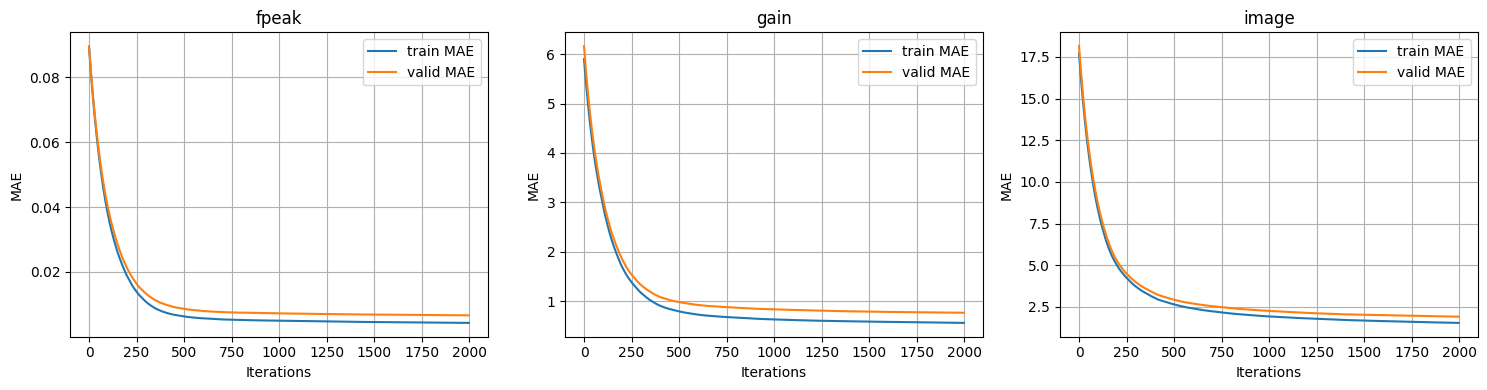

In [23]:
# 最後のFoldを代表として描画
evals = [eval_result1[-1], eval_result2[-1], eval_result3[-1]]

titles = ["fpeak", "gain", "image"]

plt.figure(figsize=(15, 4))

for i in range(3):
    plt.subplot(1, 3, i+1)

    plt.plot(evals[i]['train']['l1'], label='train MAE')
    plt.plot(evals[i]['valid']['l1'], label='valid MAE')

    plt.title(titles[i])
    plt.xlabel('Iterations')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [24]:
import shap
import numpy as np

shap.initjs()

models = [model1, model2, model3]

# ============================================================
# SHAP用サンプル
# ============================================================
X_sample = [
    train_df1.drop("fpeak", axis=1).sample(1000, random_state=42),
    train_df2.drop("gain", axis=1).sample(1000, random_state=42),
    train_df3.drop("img", axis=1).sample(1000, random_state=42)
]

# ============================================================
# SHAP上位特徴量抽出
# ============================================================
def get_shap_topk(shap_values, X, k=5):
    mean_abs = np.mean(np.abs(shap_values), axis=0)
    top_idx = np.argsort(mean_abs)[-k:]
    return shap_values[:, top_idx], X.iloc[:, top_idx]

# ============================================================
# fold平均SHAP計算
# ============================================================
shapval = []

for j, X in enumerate(X_sample):
    shap_sum = np.zeros((X.shape[0], X.shape[1]))

    for m in models[j]:
        explainer = shap.TreeExplainer(m)
        shap_sum += explainer.shap_values(X)

    shapval.append(shap_sum / len(models[j]))

# ============================================================
# 上位特徴量取得
# ============================================================
shap_top, X_top = zip(*[
    get_shap_topk(sv, X, k=5)
    for sv, X in zip(shapval, X_sample)
])

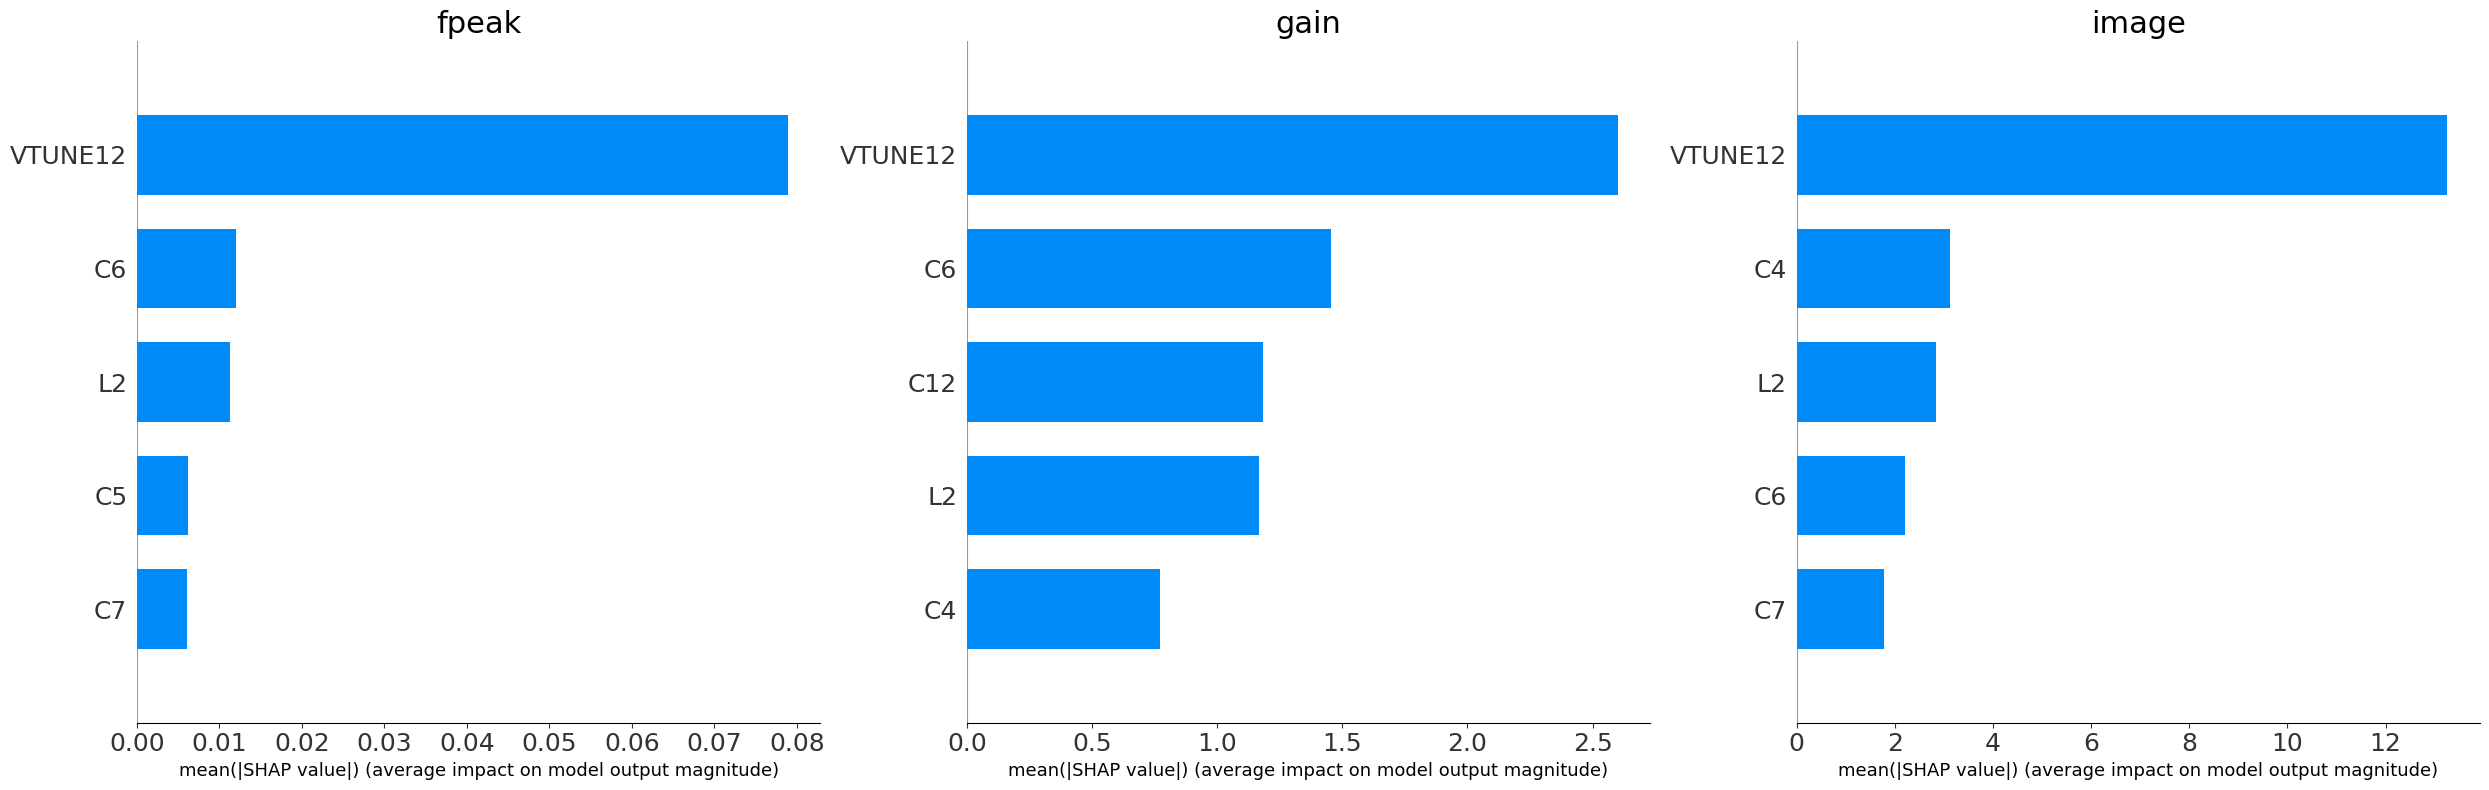

In [25]:
import shap
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 8))

titles = ["fpeak", "gain", "image"]

for i in range(3):
    ax1 = plt.subplot(1, 3, i+1)

    shap.summary_plot(
        shap_top[i],
        X_top[i],
        plot_type="bar",
        show=False,
        plot_size=None
    )

    # タイトル
    ax1.set_title(titles[i], fontsize=22)

    # x軸（importance）
    ax1.tick_params(axis='x', labelsize=18)

    # y軸（特徴量名）
    for label in ax1.get_yticklabels():
        label.set_fontsize(18)

plt.tight_layout()
plt.show()